### Importing Libraries 

In [86]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from torch import flatten #flatten the image before the FC layers. Can reshape array too!
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [87]:
!nvidia-smi

Sun Sep 25 18:03:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    28W /  70W |   1208MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [88]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# 1. MNIST classification using CNN

In [89]:
dataset = torchvision.datasets.MNIST(root='./',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.MNIST(root='./',train=False,transform=transforms.ToTensor())

In [90]:
len(dataset),len(test_dataset)

(60000, 10000)

In [91]:
torch.manual_seed(43)
val_size = 10000
train_size = len(dataset) - val_size

In [92]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [93]:
BATCH_SIZE=16

In [94]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, BATCH_SIZE*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [95]:
len(val_loader)

313

In [96]:
#train_data = torchvision.datasets.MNIST(root='./',train=True,transform=transforms.ToTensor(),download=True)
#test_data = torchvision.datasets.MNIST(root='./',train=False,transform=transforms.ToTensor())

#train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=16,shuffle=True)
#test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=16,shuffle=False)

images.shape: torch.Size([16, 1, 28, 28])


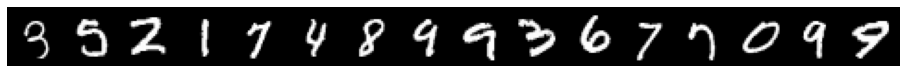

In [97]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [98]:
#BATCH_SIZE = 16
NUM_EPOCHS = 5
HIDDEN_SIZE = 500
NUM_CLASSES = 10
VAL_SPLIT = 0.1

### Defining a class with the required CNN architecture


In [99]:

class CNN(nn.Module): #nn.Module helps us build our model as a class making it easy to reuse variables
    
    def __init__(self,num_classes=NUM_CLASSES): #class constructor
        super(CNN,self).__init__() #calls the parent constructor
        
        #initializing first set of layers: CONV 32 filters 3x3 with padding = 1 + ReLU activation + 2x2 Max Pooling with Stride 2
        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))) #nn.Sequential is a wrapper which combines all these together
        
        #initializing second set of layers: CONV 32 filters 3x3 with padding = 1 + RelU activation + 2x2 Max Pooling with Stride 2
        self.layer2 = nn.Sequential(nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
        
        #initializing final set of layers: The fully connected part [500,10] 
        
        self.fc_layer1 = nn.Sequential(nn.Linear(7*7*32, 500),nn.ReLU()) #first fully connected layer
        self.fc_layer2 = nn.Linear(500,10)
        #self.logsoftmax = nn.LogSoftmax(dim = 1)
        
        
    
    def forward(self,x): #defines the structure of the network thus help in performing backprop, it does forward pass
        
        output = self.layer1(x.float()) #converting x to float datatype
        output = self.layer2(output)
        output = flatten(output,1)
        output = self.fc_layer1(output)
        output = self.fc_layer2(output)
        
        #pred   = self.logsoftmax(output)
        
        return output
    

### Defining a class CNN with Batch Normalization 

In [100]:
class CNN_with_Batch_Norm(nn.Module): #CNN but with Batch Normalization 
    
    def __init__(self,num_classes=NUM_CLASSES): #class constructor
        super(CNN_with_Batch_Norm,self).__init__() #calls the parent constructor
        
        #initializing first set of layers: CONV 32 filters 3x3 with padding = 1 + ReLU activation + 2x2 Max Pooling with Stride 2
        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),nn.BatchNorm2d(32)) #nn.Sequential is a wrapper which combines all these together
        
        #initializing second set of layers: CONV 32 filters 3x3 with padding = 1 + RelU activation + 2x2 Max Pooling with Stride 2
        self.layer2 = nn.Sequential(nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1), nn.ReLU(),nn.BatchNorm2d(32), nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
        
        #initializing final set of layers: The fully connected part [500,10] 
        
        self.fc_layer1 = nn.Sequential(nn.Linear(7*7*32, 500),nn.ReLU()) #first fully connected layer
        self.fc_layer2 = nn.Linear(500,10)
        #self.logsoftmax = nn.LogSoftmax(dim = 1)


    def forward(self,x): #defines the structure of the network thus help in performing backprop, it does forward pass
        
        output = self.layer1(x.float()) #converting x to float datatype
        output = self.layer2(output)
        output = flatten(output,1)
        output = self.fc_layer1(output)
        output = self.fc_layer2(output)
        
        #pred   = self.logsoftmax(output)
        
        return output   

In [101]:
CUDA_LAUNCH_BLOCKING=1

### CNN Training 

In [102]:
model = CNN().to(device)


In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [104]:
total_steps = len(train_loader)
cost_train,cost_val,acc = [],[],[]
for epoch in range(NUM_EPOCHS):
  for i, (images,labels) in tqdm_notebook(enumerate(train_loader)):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
      print('Epoch:[{}/{}], Step:{}/{}, Loss:{:.6f}'.format(epoch+1,NUM_EPOCHS,i+1,total_steps,loss.item()))
      model.eval()
      with torch.no_grad():
        correct,total = 0,0
        for images,labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)

          preds = model(images)
          val_loss = criterion(preds,labels)
          _,pred = torch.max(preds.data,1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()

        print('Validation Loss:{:4f}, Validation Accuracy:{:.4f}'.format(val_loss.item(),correct/total))
        cost_train.append(loss.item())
        acc.append(correct/total)
        cost_val.append(val_loss.item())
   #train_correct /= train_length #training accuracy 
    
torch.save(model.state_dict(),'model.ckpt')

0it [00:00, ?it/s]

Epoch:[1/5], Step:200/3125, Loss:0.264354
Validation Loss:0.143680, Validation Accuracy:0.9221
Epoch:[1/5], Step:400/3125, Loss:0.073196
Validation Loss:0.059148, Validation Accuracy:0.9505
Epoch:[1/5], Step:600/3125, Loss:0.118357
Validation Loss:0.058303, Validation Accuracy:0.9631
Epoch:[1/5], Step:800/3125, Loss:0.003932
Validation Loss:0.034843, Validation Accuracy:0.9699
Epoch:[1/5], Step:1000/3125, Loss:0.058530
Validation Loss:0.150711, Validation Accuracy:0.9641
Epoch:[1/5], Step:1200/3125, Loss:0.340549
Validation Loss:0.044896, Validation Accuracy:0.9668
Epoch:[1/5], Step:1400/3125, Loss:0.077259
Validation Loss:0.061422, Validation Accuracy:0.9759
Epoch:[1/5], Step:1600/3125, Loss:0.026313
Validation Loss:0.010501, Validation Accuracy:0.9740
Epoch:[1/5], Step:1800/3125, Loss:0.156405
Validation Loss:0.001969, Validation Accuracy:0.9726
Epoch:[1/5], Step:2000/3125, Loss:0.071861
Validation Loss:0.009756, Validation Accuracy:0.9797
Epoch:[1/5], Step:2200/3125, Loss:0.013287
V

0it [00:00, ?it/s]

Epoch:[2/5], Step:200/3125, Loss:0.001364
Validation Loss:0.055774, Validation Accuracy:0.9830
Epoch:[2/5], Step:400/3125, Loss:0.002403
Validation Loss:0.008490, Validation Accuracy:0.9820
Epoch:[2/5], Step:600/3125, Loss:0.001219
Validation Loss:0.026547, Validation Accuracy:0.9806
Epoch:[2/5], Step:800/3125, Loss:0.001245
Validation Loss:0.002734, Validation Accuracy:0.9831
Epoch:[2/5], Step:1000/3125, Loss:0.068009
Validation Loss:0.269920, Validation Accuracy:0.9750
Epoch:[2/5], Step:1200/3125, Loss:0.069400
Validation Loss:0.008473, Validation Accuracy:0.9805
Epoch:[2/5], Step:1400/3125, Loss:0.038664
Validation Loss:0.040419, Validation Accuracy:0.9790
Epoch:[2/5], Step:1600/3125, Loss:0.053146
Validation Loss:0.015491, Validation Accuracy:0.9788
Epoch:[2/5], Step:1800/3125, Loss:0.001013
Validation Loss:0.000490, Validation Accuracy:0.9849
Epoch:[2/5], Step:2000/3125, Loss:0.266701
Validation Loss:0.003298, Validation Accuracy:0.9814
Epoch:[2/5], Step:2200/3125, Loss:0.007998
V

0it [00:00, ?it/s]

Epoch:[3/5], Step:200/3125, Loss:0.005289
Validation Loss:0.003066, Validation Accuracy:0.9812
Epoch:[3/5], Step:400/3125, Loss:0.000700
Validation Loss:0.001207, Validation Accuracy:0.9877
Epoch:[3/5], Step:600/3125, Loss:0.001074
Validation Loss:0.000299, Validation Accuracy:0.9873
Epoch:[3/5], Step:800/3125, Loss:0.019573
Validation Loss:0.000708, Validation Accuracy:0.9850
Epoch:[3/5], Step:1000/3125, Loss:0.341197
Validation Loss:0.001474, Validation Accuracy:0.9843
Epoch:[3/5], Step:1200/3125, Loss:0.122271
Validation Loss:0.011026, Validation Accuracy:0.9856
Epoch:[3/5], Step:1400/3125, Loss:0.001493
Validation Loss:0.004576, Validation Accuracy:0.9838
Epoch:[3/5], Step:1600/3125, Loss:0.000031
Validation Loss:0.001857, Validation Accuracy:0.9845
Epoch:[3/5], Step:1800/3125, Loss:0.004224
Validation Loss:0.001325, Validation Accuracy:0.9864
Epoch:[3/5], Step:2000/3125, Loss:0.003275
Validation Loss:0.000473, Validation Accuracy:0.9858
Epoch:[3/5], Step:2200/3125, Loss:0.066911
V

0it [00:00, ?it/s]

Epoch:[4/5], Step:200/3125, Loss:0.000041
Validation Loss:0.000565, Validation Accuracy:0.9892
Epoch:[4/5], Step:400/3125, Loss:0.000092
Validation Loss:0.000345, Validation Accuracy:0.9878
Epoch:[4/5], Step:600/3125, Loss:0.015437
Validation Loss:0.000205, Validation Accuracy:0.9880
Epoch:[4/5], Step:800/3125, Loss:0.679231
Validation Loss:0.000360, Validation Accuracy:0.9895
Epoch:[4/5], Step:1000/3125, Loss:0.000038
Validation Loss:0.000208, Validation Accuracy:0.9880
Epoch:[4/5], Step:1200/3125, Loss:0.004923
Validation Loss:0.001467, Validation Accuracy:0.9873
Epoch:[4/5], Step:1400/3125, Loss:0.096855
Validation Loss:0.002822, Validation Accuracy:0.9887
Epoch:[4/5], Step:1600/3125, Loss:0.000056
Validation Loss:0.000182, Validation Accuracy:0.9864
Epoch:[4/5], Step:1800/3125, Loss:0.000001
Validation Loss:0.000270, Validation Accuracy:0.9840
Epoch:[4/5], Step:2000/3125, Loss:0.012497
Validation Loss:0.000354, Validation Accuracy:0.9875
Epoch:[4/5], Step:2200/3125, Loss:0.022617
V

0it [00:00, ?it/s]

Epoch:[5/5], Step:200/3125, Loss:0.012389
Validation Loss:0.000237, Validation Accuracy:0.9879
Epoch:[5/5], Step:400/3125, Loss:0.002311
Validation Loss:0.000307, Validation Accuracy:0.9896
Epoch:[5/5], Step:600/3125, Loss:0.000090
Validation Loss:0.000465, Validation Accuracy:0.9892
Epoch:[5/5], Step:800/3125, Loss:0.683075
Validation Loss:0.001330, Validation Accuracy:0.9874
Epoch:[5/5], Step:1000/3125, Loss:0.005624
Validation Loss:0.000276, Validation Accuracy:0.9889
Epoch:[5/5], Step:1200/3125, Loss:0.000078
Validation Loss:0.000078, Validation Accuracy:0.9901
Epoch:[5/5], Step:1400/3125, Loss:0.002686
Validation Loss:0.002623, Validation Accuracy:0.9867
Epoch:[5/5], Step:1600/3125, Loss:0.001416
Validation Loss:0.023006, Validation Accuracy:0.9854
Epoch:[5/5], Step:1800/3125, Loss:0.054683
Validation Loss:0.000698, Validation Accuracy:0.9846
Epoch:[5/5], Step:2000/3125, Loss:0.000352
Validation Loss:0.001745, Validation Accuracy:0.9873
Epoch:[5/5], Step:2200/3125, Loss:0.035533
V

### CNN Testing




In [105]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

### <font color='red'>1.2 Plot randomly selected test images showing the true and predicted class labels. </font> 

Label: 2 - two , Predicted: 2 - two


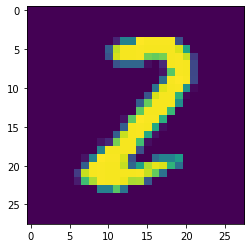

In [106]:
img, label = test_dataset[1002]
plt.imshow(img.reshape(28,28))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [107]:
model.eval()
cost_test = []
acc_test = []
with torch.no_grad():
    correct,total = 0,0
    for images,labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      preds = model(images)
      test_loss = criterion(preds,labels)
      _,pred = torch.max(preds.data,1)
      total += labels.size(0)
      correct += (pred == labels).sum().item()
      acc_test.append(correct/total)

    print('Test Loss:{:4f}, Final Test Accuracy:{:.4f}'.format(test_loss.item(),correct/total))
    cost_test.append(test_loss.item())

Test Loss:0.000043, Final Test Accuracy:0.9903


###  <font color='red'>1.1 Plot Training  error and validation error and average prediction accuracy </font> 

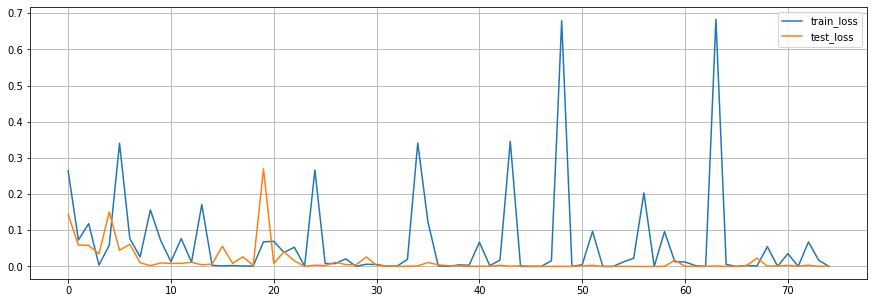

In [108]:
x = np.arange(len(cost_train))
plt.figure(figsize=(15,5))
plt.plot(x,cost_train,label='train_loss')
plt.plot(x,cost_val,label='test_loss')
plt.legend()
plt.grid()
plt.show()

In [109]:
avg_acc = sum(acc_test)/len(acc_test)
print (avg_acc)

0.9870770680800125


### <font color='red'>1.1 Prediction Accuracy Plot</font>

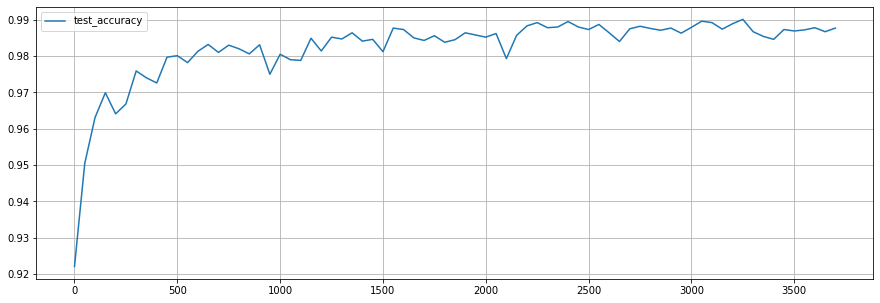

In [110]:
x = 50*np.arange(len(cost_train))
plt.figure(figsize=(15,5))
plt.plot(x,acc,label='test_accuracy')
plt.legend()
plt.grid()
plt.show()

### <font color = 'red'>1.6 Training CNN with Batch Normalization

In [111]:
model_bn = CNN_with_Batch_Norm().to(device)

In [112]:
optimizer = torch.optim.Adam(model_bn.parameters())


In [113]:
total_steps = len(train_loader)
cost_train_bn,cost_val_bn,acc_bn = [],[],[]
for epoch in range(NUM_EPOCHS):
  for i, (images,labels) in tqdm_notebook(enumerate(train_loader)):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model_bn(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 200 == 0:
      print('Epoch:[{}/{}], Step:{}/{}, Loss:{:.6f}'.format(epoch+1,NUM_EPOCHS,i+1,total_steps,loss.item()))
      model_bn.eval()
      with torch.no_grad():
        correct,total = 0,0
        for images,labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          preds = model_bn(images)
          val_loss = criterion(preds,labels)
          _,pred = torch.max(preds.data,1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()

        print('Validation Loss:{:4f}, Validation Accuracy:{:.4f}'.format(val_loss.item(),correct/total))
        cost_val_bn.append(val_loss.item())
        acc_bn.append(correct/total)
        cost_train_bn.append(loss.item())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0it [00:00, ?it/s]

Epoch:[1/5], Step:200/3125, Loss:0.109064
Validation Loss:0.174089, Validation Accuracy:0.9420
Epoch:[1/5], Step:400/3125, Loss:0.042508
Validation Loss:0.113337, Validation Accuracy:0.9620
Epoch:[1/5], Step:600/3125, Loss:0.062289
Validation Loss:0.145564, Validation Accuracy:0.9667
Epoch:[1/5], Step:800/3125, Loss:0.002126
Validation Loss:0.024114, Validation Accuracy:0.9736
Epoch:[1/5], Step:1000/3125, Loss:0.000615
Validation Loss:0.028649, Validation Accuracy:0.9727
Epoch:[1/5], Step:1200/3125, Loss:0.037962
Validation Loss:0.066408, Validation Accuracy:0.9655
Epoch:[1/5], Step:1400/3125, Loss:0.018443
Validation Loss:0.006943, Validation Accuracy:0.9758
Epoch:[1/5], Step:1600/3125, Loss:0.032906
Validation Loss:0.062022, Validation Accuracy:0.9758
Epoch:[1/5], Step:1800/3125, Loss:0.003075
Validation Loss:0.006573, Validation Accuracy:0.9790
Epoch:[1/5], Step:2000/3125, Loss:0.010395
Validation Loss:0.056744, Validation Accuracy:0.9758
Epoch:[1/5], Step:2200/3125, Loss:0.153677
V

0it [00:00, ?it/s]

Epoch:[2/5], Step:200/3125, Loss:0.046710
Validation Loss:0.041039, Validation Accuracy:0.9809
Epoch:[2/5], Step:400/3125, Loss:0.138606
Validation Loss:0.064438, Validation Accuracy:0.9750
Epoch:[2/5], Step:600/3125, Loss:0.017906
Validation Loss:0.026209, Validation Accuracy:0.9838
Epoch:[2/5], Step:800/3125, Loss:0.002449
Validation Loss:0.011318, Validation Accuracy:0.9764
Epoch:[2/5], Step:1000/3125, Loss:0.004158
Validation Loss:0.002552, Validation Accuracy:0.9790
Epoch:[2/5], Step:1200/3125, Loss:0.303105
Validation Loss:0.030334, Validation Accuracy:0.9830
Epoch:[2/5], Step:1400/3125, Loss:0.023104
Validation Loss:0.012510, Validation Accuracy:0.9778
Epoch:[2/5], Step:1600/3125, Loss:0.002514
Validation Loss:0.001266, Validation Accuracy:0.9846
Epoch:[2/5], Step:1800/3125, Loss:0.009460
Validation Loss:0.001112, Validation Accuracy:0.9811
Epoch:[2/5], Step:2000/3125, Loss:0.017270
Validation Loss:0.000605, Validation Accuracy:0.9838
Epoch:[2/5], Step:2200/3125, Loss:0.113676
V

0it [00:00, ?it/s]

Epoch:[3/5], Step:200/3125, Loss:0.000596
Validation Loss:0.000795, Validation Accuracy:0.9852
Epoch:[3/5], Step:400/3125, Loss:0.000161
Validation Loss:0.002170, Validation Accuracy:0.9836
Epoch:[3/5], Step:600/3125, Loss:0.000212
Validation Loss:0.078547, Validation Accuracy:0.9832
Epoch:[3/5], Step:800/3125, Loss:0.006442
Validation Loss:0.014844, Validation Accuracy:0.9833
Epoch:[3/5], Step:1000/3125, Loss:0.232877
Validation Loss:0.000119, Validation Accuracy:0.9858
Epoch:[3/5], Step:1200/3125, Loss:0.000043
Validation Loss:0.001015, Validation Accuracy:0.9831
Epoch:[3/5], Step:1400/3125, Loss:0.000640
Validation Loss:0.002518, Validation Accuracy:0.9843
Epoch:[3/5], Step:1600/3125, Loss:0.000012
Validation Loss:0.000585, Validation Accuracy:0.9834
Epoch:[3/5], Step:1800/3125, Loss:0.000289
Validation Loss:0.310779, Validation Accuracy:0.9768
Epoch:[3/5], Step:2000/3125, Loss:0.000067
Validation Loss:0.000482, Validation Accuracy:0.9767
Epoch:[3/5], Step:2200/3125, Loss:0.395895
V

0it [00:00, ?it/s]

Epoch:[4/5], Step:200/3125, Loss:0.000000
Validation Loss:0.000214, Validation Accuracy:0.9889
Epoch:[4/5], Step:400/3125, Loss:0.004593
Validation Loss:0.018723, Validation Accuracy:0.9836
Epoch:[4/5], Step:600/3125, Loss:0.000105
Validation Loss:0.021199, Validation Accuracy:0.9873
Epoch:[4/5], Step:800/3125, Loss:0.000049
Validation Loss:0.006743, Validation Accuracy:0.9850
Epoch:[4/5], Step:1000/3125, Loss:0.034795
Validation Loss:0.159769, Validation Accuracy:0.9847
Epoch:[4/5], Step:1200/3125, Loss:0.001409
Validation Loss:0.060328, Validation Accuracy:0.9802
Epoch:[4/5], Step:1400/3125, Loss:0.000523
Validation Loss:0.235742, Validation Accuracy:0.9861
Epoch:[4/5], Step:1600/3125, Loss:0.000587
Validation Loss:0.006114, Validation Accuracy:0.9867
Epoch:[4/5], Step:1800/3125, Loss:0.000001
Validation Loss:0.000791, Validation Accuracy:0.9873
Epoch:[4/5], Step:2000/3125, Loss:0.000012
Validation Loss:0.002314, Validation Accuracy:0.9868
Epoch:[4/5], Step:2200/3125, Loss:0.008418
V

0it [00:00, ?it/s]

Epoch:[5/5], Step:200/3125, Loss:0.000002
Validation Loss:0.000470, Validation Accuracy:0.9872
Epoch:[5/5], Step:400/3125, Loss:0.000000
Validation Loss:0.000004, Validation Accuracy:0.9876
Epoch:[5/5], Step:600/3125, Loss:0.000012
Validation Loss:0.049347, Validation Accuracy:0.9841
Epoch:[5/5], Step:800/3125, Loss:0.000033
Validation Loss:0.000362, Validation Accuracy:0.9850
Epoch:[5/5], Step:1000/3125, Loss:0.000159
Validation Loss:0.004719, Validation Accuracy:0.9877
Epoch:[5/5], Step:1200/3125, Loss:0.000039
Validation Loss:0.000067, Validation Accuracy:0.9836
Epoch:[5/5], Step:1400/3125, Loss:0.000159
Validation Loss:0.000025, Validation Accuracy:0.9877
Epoch:[5/5], Step:1600/3125, Loss:0.000021
Validation Loss:0.000969, Validation Accuracy:0.9854
Epoch:[5/5], Step:1800/3125, Loss:0.000064
Validation Loss:0.000002, Validation Accuracy:0.9859
Epoch:[5/5], Step:2000/3125, Loss:0.106716
Validation Loss:0.000666, Validation Accuracy:0.9844
Epoch:[5/5], Step:2200/3125, Loss:0.000014
V

### CNN with Batch Normalization Testing 

Label: 7 - seven , Predicted: 7 - seven


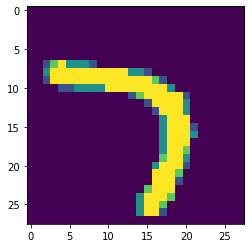

In [114]:
def predict_image(img, model_bn):
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model_bn(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

img, label = test_dataset[60]
plt.imshow(img.reshape(28,28))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_bn))

In [115]:
acc_test_bn =[]
cost_test_bn=[]
model_bn.eval()
with torch.no_grad():
    correct,total = 0,0
    for images,labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)
      preds = model_bn(images)
      test_loss = criterion(preds,labels)
      _,pred = torch.max(preds.data,1)
      total += labels.size(0)
      correct += (pred == labels).sum().item()
      acc_test_bn.append(correct/total)

    print('Test Loss:{:4f}, Final Test Accuracy:{:.4f}'.format(test_loss.item(),correct/total))
    cost_test_bn.append(test_loss.item())

Test Loss:0.000725, Final Test Accuracy:0.9865


### Average prediction accuracy

In [116]:
avg_acc_bn = sum(acc_test_bn)/len(acc_test_bn)
print (avg_acc_bn)

0.9862817655173399


<font color = 'red'>From here it is clear that the avg test accuracy with batch normalisation is greater than the avg test accuracy without batch normalisation and the time taken to train the model is also less using the batch normalisation. </font>

### Plot Training  error and validation error 

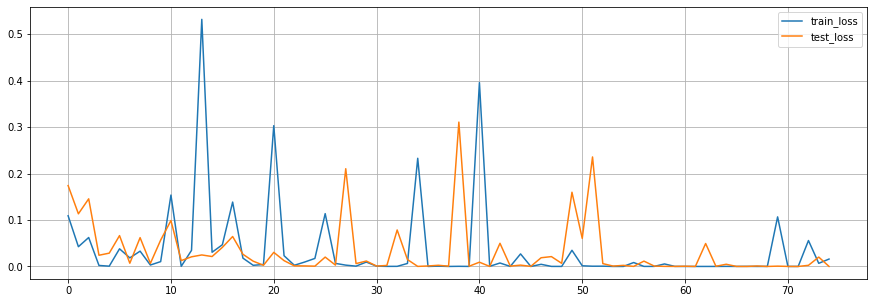

In [117]:
x = np.arange(len(cost_train_bn))
plt.figure(figsize=(15,5))
plt.plot(x,cost_train_bn,label='train_loss')
plt.plot(x,cost_val_bn,label='test_loss')
plt.legend()
plt.grid()
plt.show()

### Prediction Accuracy Plot 

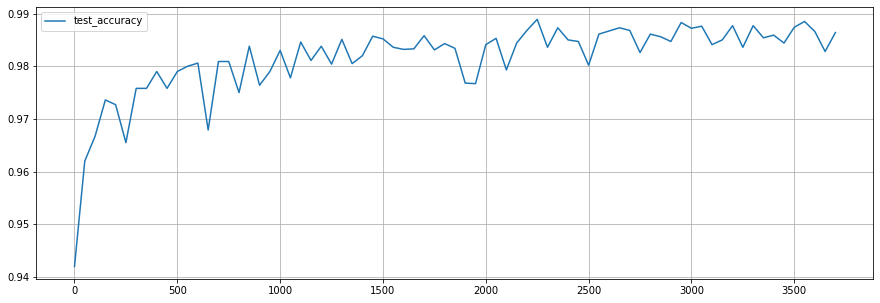

In [118]:
x = 50*np.arange(len(cost_train_bn))
plt.figure(figsize=(15,5))
plt.plot(x,acc_bn,label='test_accuracy')
plt.legend()
plt.grid()
plt.show()

### Plot prediction accuracy with and without normalization 

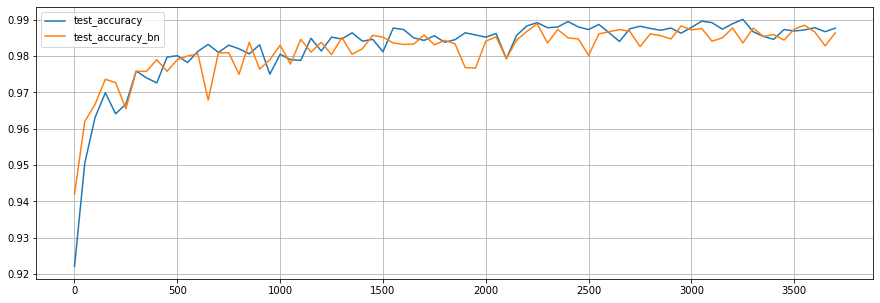

In [123]:
x = 50*np.arange(len(cost_train_bn))
plt.figure(figsize=(15,5))
plt.plot(x,acc,label='test_accuracy')
plt.plot(x,acc_bn,label='test_accuracy_bn')
plt.legend()
plt.grid()
plt.show()

### <font color = 'red'>1.3, 1.4, 1.5 All three questions are clear from given outputs </font>

In [120]:
torch.save(model.state_dict(),'model.ckpt')
checkpoint = torch.load('model.ckpt')
model = CNN().to(device)
model.load_state_dict(checkpoint)
model.eval()
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

layer1.0.weight 	 torch.Size([32, 1, 3, 3])
layer1.0.bias 	 torch.Size([32])
layer2.0.weight 	 torch.Size([32, 32, 3, 3])
layer2.0.bias 	 torch.Size([32])
fc_layer1.0.weight 	 torch.Size([500, 1568])
fc_layer1.0.bias 	 torch.Size([500])
fc_layer2.weight 	 torch.Size([10, 500])
fc_layer2.bias 	 torch.Size([10])


In [121]:
torch.save(model_bn.state_dict(),'model_bn.ckpt')
checkpoint = torch.load('model_bn.ckpt')
model_bn = CNN_with_Batch_Norm().to(device)
model_bn.load_state_dict(checkpoint)
model_bn.eval()
for param_tensor in model_bn.state_dict():
    print(param_tensor, "\t", model_bn.state_dict()[param_tensor].size())

layer1.0.weight 	 torch.Size([32, 1, 3, 3])
layer1.0.bias 	 torch.Size([32])
layer1.3.weight 	 torch.Size([32])
layer1.3.bias 	 torch.Size([32])
layer1.3.running_mean 	 torch.Size([32])
layer1.3.running_var 	 torch.Size([32])
layer1.3.num_batches_tracked 	 torch.Size([])
layer2.0.weight 	 torch.Size([32, 32, 3, 3])
layer2.0.bias 	 torch.Size([32])
layer2.2.weight 	 torch.Size([32])
layer2.2.bias 	 torch.Size([32])
layer2.2.running_mean 	 torch.Size([32])
layer2.2.running_var 	 torch.Size([32])
layer2.2.num_batches_tracked 	 torch.Size([])
fc_layer1.0.weight 	 torch.Size([500, 1568])
fc_layer1.0.bias 	 torch.Size([500])
fc_layer2.weight 	 torch.Size([10, 500])
fc_layer2.bias 	 torch.Size([10])


### 2.1 Plot the the conv1 layer filters. Do you observe interesting patterns?

In [36]:
conv1_layer = model.state_dict()['layer1.0.weight'].cpu().numpy()
conv2_layer = model.state_dict()['layer2.0.weight'].cpu().numpy()

def normalize(x,eps=1e-8):
  out = np.zeros_like(x)
  for i in range(x.shape[0]):
    high,low = np.amax(x[i]),np.amin(x[i])
    out[i] = (x[i]-low)/(high-low+eps)
  
  out = out*255
  out = out.astype(np.uint8)
  return out

conv1_layer_normal = normalize(conv1_layer)
conv2_layer_normal = normalize(conv2_layer)

print(conv1_layer_normal.shape)

(32, 1, 3, 3)


In [37]:
conv1_layer_normal = conv1_layer_normal.reshape(32,3,3)

In [38]:
print(conv2_layer_normal.shape)

(32, 32, 3, 3)


# 2. Visualizing the Convolution Neural Network



### <font color = 'red'>2.1 Plot the First convolution layer </font>



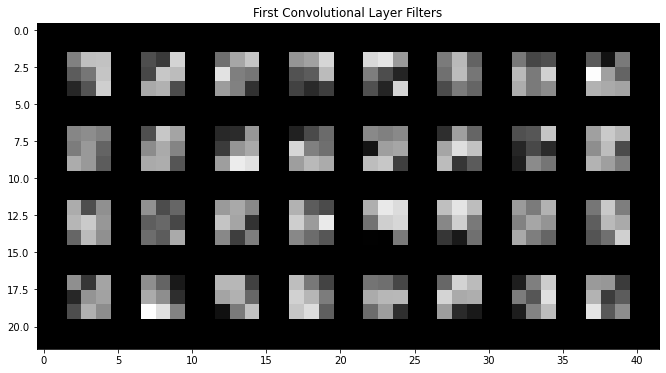

In [39]:
conv1_filter = model.layer1[0].weight.detach().clone() #creating a copy of the filter weights
conv1_filter = conv1_filter.cpu() #get it to the CPU

#normalizing the filters by scaling the values makes it stand out from the background
conv1_filter -= conv1_filter.min() #subtracting a negative value will make the image stand out,makes it "whiter"
conv1_filter /= conv1_filter.max() # there will be 32 such filters
image = make_grid(conv1_filter) #this returns a tensor grid containing the images
#print(image.size()) 
image = image.permute(1,2,0) #permuting the dimensions of the tensor grid to make it right ie, 3x3x32
#print(image.size())

#plotting the first layer filters
plt.figure(figsize = (15,6))
plt.imshow(image)
plt.title('First Convolutional Layer Filters')
plt.show()

### <font color = 'red'>2.2 Plot the Second convolution layer</font>

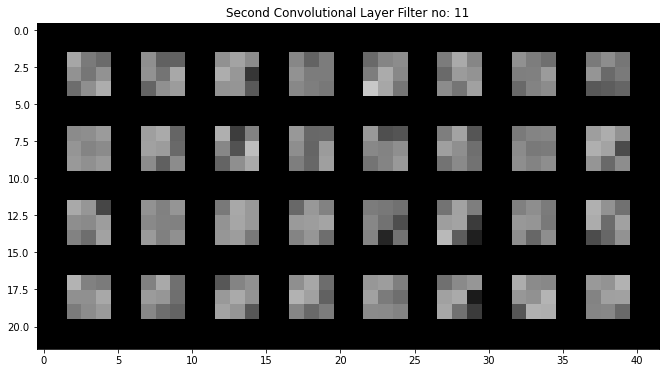

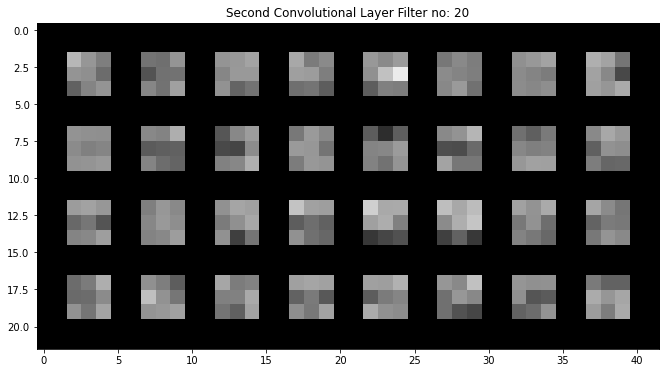

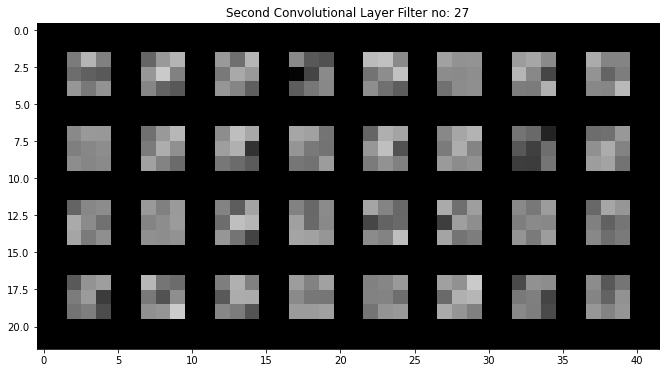

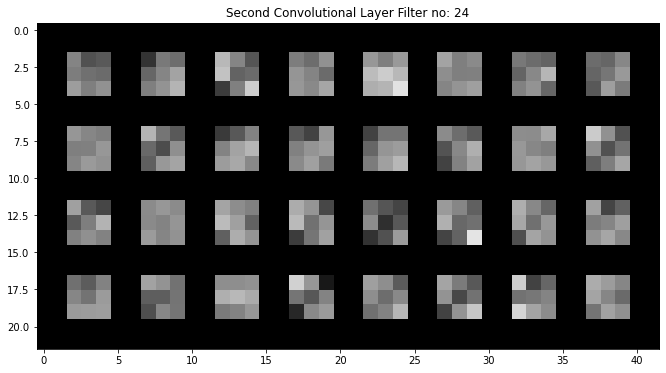

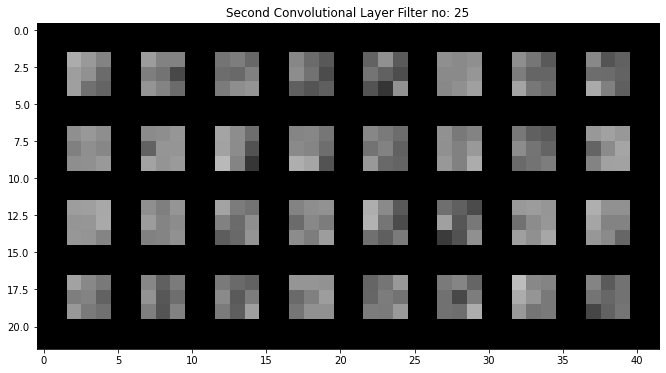

In [40]:
conv2_filter = model.layer2[0].weight.detach().clone() #creating a copy of the filter weights

#if(device == torch.device('cuda')):
conv2_filter = conv2_filter.cpu() #get it to the CPU

#normalizing the filters by scaling the values this makes it stand out from the background

conv2_filter -= conv2_filter.min()
conv2_filter /= conv2_filter.max() # there will be 32 such block filters of dim 3x3x32
#print(conv2_filter.size()) 

#Therefore, using a random number generator to choose which block filters to plot
filt_ind = np.random.randint(0 , 31, 5) #as we're gonna plot 5 such filters

for ind in filt_ind:    

    image  = make_grid(conv2_filter[ind].reshape(conv1_filter.size())) #this returns a tensor grid containing the images
    image  = image.permute(1,2,0) #permuting the dimensions of the tensor grid to make it right 

    #plotting the second layer filters
    plt.figure(figsize = (15,6))
    plt.imshow(image)
    str_title = 'Second Convolutional Layer Filter no: ' + str(ind)
    plt.title(str_title)
    plt.show()

### <font color = 'red '>2.3 Visualise the activation </font>



<font color ='red'>We can observe that in the first convolution layer we get to see the low level features like edges while when we go into deeper layer we can not exactly comprehend which is high  level of features </font>

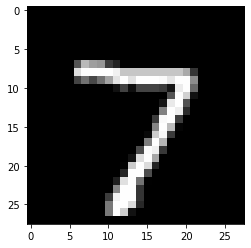

In [41]:
test_image = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)
for images,labels in test_image:
  images = images.to(device)
  img = images.cpu().numpy().reshape(28,28)
  plt.imshow(img,'gray')
  plt.show()

  layer1_out = model.layer1(images)
  layer1_out_np = layer1_out.cpu().detach().numpy().reshape(32,14,14)

  layer2_out = model.layer2(layer1_out)
  layer2_out_np = layer2_out.cpu().detach().numpy().reshape(32,7,7)

  break

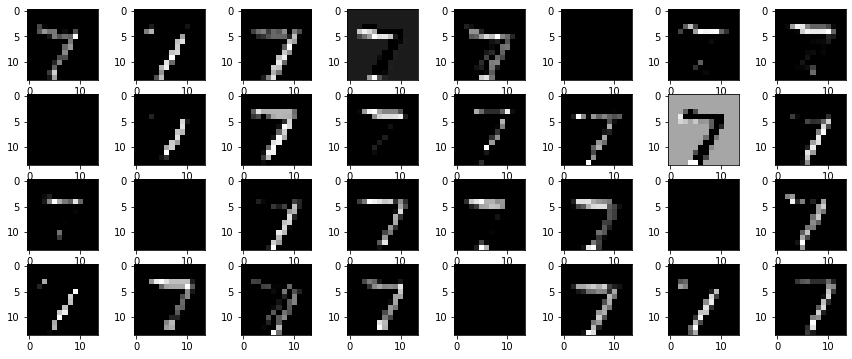

In [42]:
fig = plt.figure(figsize=(15,6))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(layer1_out_np[i-1],'gray')

plt.show()

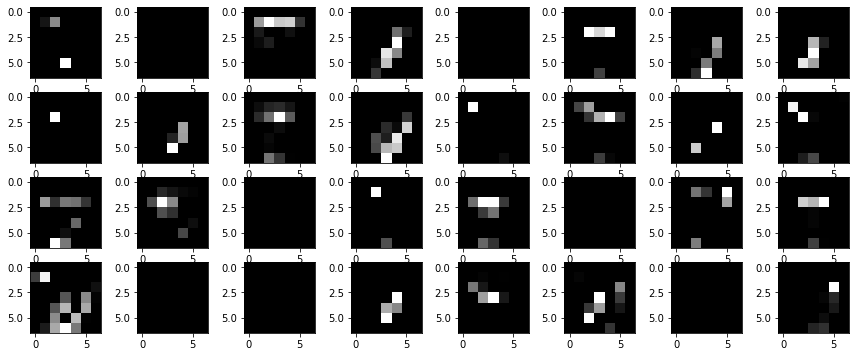

In [43]:
fig = plt.figure(figsize=(15,6))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(layer2_out_np[i-1],'gray')

plt.show()

### <font color ='red'>2.4 Occclusion of Image
        

In [44]:
def occluded_image(x,i,j,patch_size=14):
  
  y = x.copy()
  y[i:i+patch_size,j:j+patch_size] = 0.5
  return y

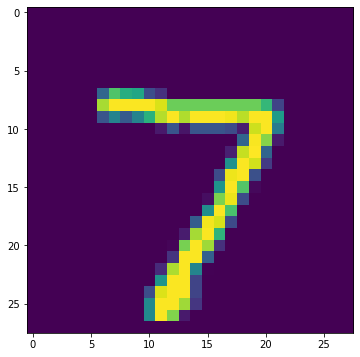

Figure:1, Actual Class:7, Probability:1.0000, Predicted:7
Figure:2, Actual Class:7, Probability:0.9996, Predicted:7
Figure:3, Actual Class:7, Probability:1.0000, Predicted:7
Figure:4, Actual Class:7, Probability:0.9998, Predicted:7
Figure:5, Actual Class:7, Probability:0.9475, Predicted:7
Figure:6, Actual Class:7, Probability:1.0000, Predicted:7
Figure:7, Actual Class:7, Probability:0.9999, Predicted:7
Figure:8, Actual Class:7, Probability:0.9999, Predicted:7
Figure:9, Actual Class:7, Probability:1.0000, Predicted:7


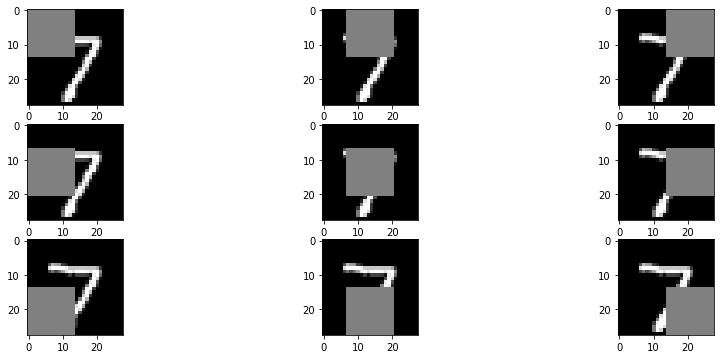

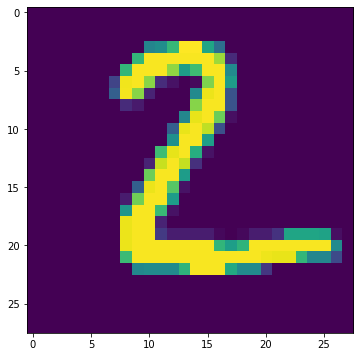

Figure:1, Actual Class:2, Probability:1.0000, Predicted:2
Figure:2, Actual Class:2, Probability:0.9994, Predicted:2
Figure:3, Actual Class:2, Probability:1.0000, Predicted:2
Figure:4, Actual Class:2, Probability:0.9950, Predicted:2
Figure:5, Actual Class:2, Probability:0.9998, Predicted:2
Figure:6, Actual Class:2, Probability:1.0000, Predicted:2
Figure:7, Actual Class:2, Probability:1.0000, Predicted:2
Figure:8, Actual Class:2, Probability:1.0000, Predicted:2
Figure:9, Actual Class:2, Probability:0.9997, Predicted:2


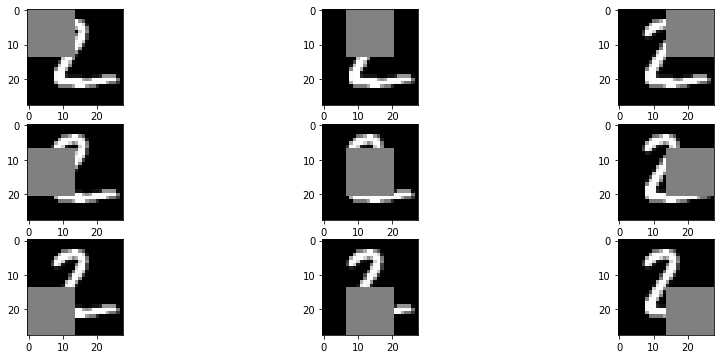

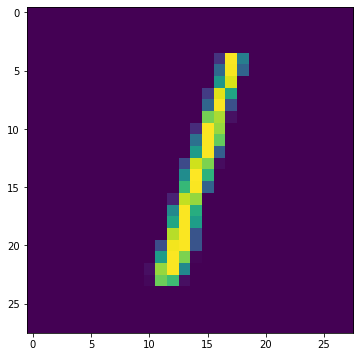

Figure:1, Actual Class:1, Probability:0.9041, Predicted:1
Figure:2, Actual Class:1, Probability:0.2145, Predicted:8
Figure:3, Actual Class:1, Probability:0.3263, Predicted:8
Figure:4, Actual Class:1, Probability:0.8983, Predicted:1
Figure:5, Actual Class:1, Probability:0.0884, Predicted:4
Figure:6, Actual Class:1, Probability:0.7100, Predicted:1
Figure:7, Actual Class:1, Probability:0.9976, Predicted:1
Figure:8, Actual Class:1, Probability:0.7993, Predicted:1
Figure:9, Actual Class:1, Probability:0.9993, Predicted:1


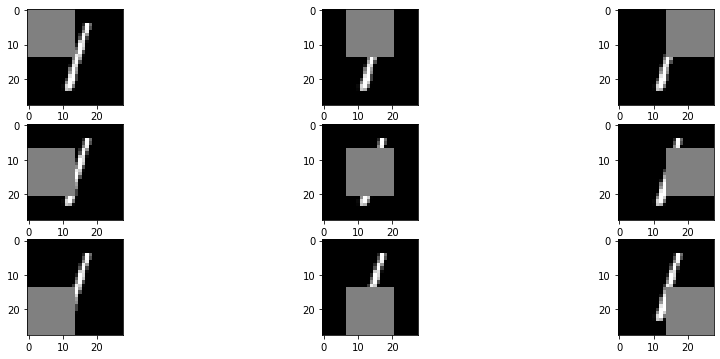

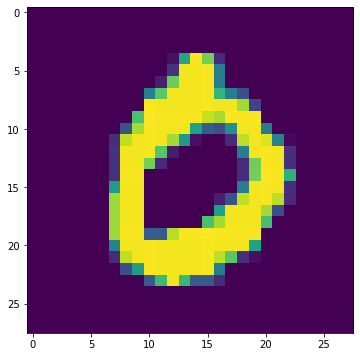

Figure:1, Actual Class:0, Probability:1.0000, Predicted:0
Figure:2, Actual Class:0, Probability:0.7257, Predicted:0
Figure:3, Actual Class:0, Probability:0.8581, Predicted:0
Figure:4, Actual Class:0, Probability:0.9420, Predicted:0
Figure:5, Actual Class:0, Probability:0.5986, Predicted:0
Figure:6, Actual Class:0, Probability:0.9967, Predicted:0
Figure:7, Actual Class:0, Probability:0.9973, Predicted:0
Figure:8, Actual Class:0, Probability:0.9079, Predicted:0
Figure:9, Actual Class:0, Probability:1.0000, Predicted:0


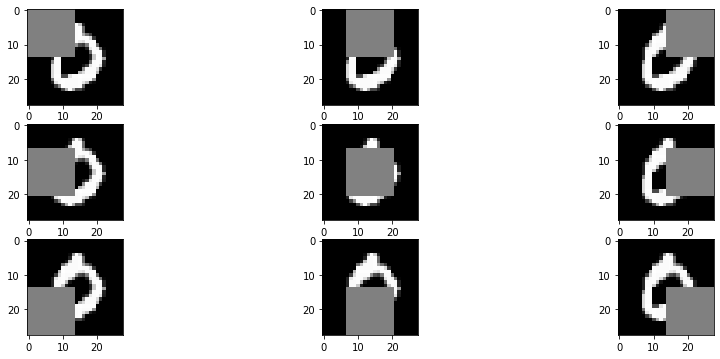

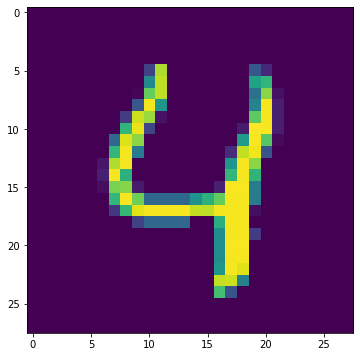

Figure:1, Actual Class:4, Probability:0.9768, Predicted:4
Figure:2, Actual Class:4, Probability:0.0234, Predicted:9
Figure:3, Actual Class:4, Probability:0.9511, Predicted:4
Figure:4, Actual Class:4, Probability:0.9631, Predicted:4
Figure:5, Actual Class:4, Probability:0.3718, Predicted:4
Figure:6, Actual Class:4, Probability:0.9846, Predicted:4
Figure:7, Actual Class:4, Probability:0.9996, Predicted:4
Figure:8, Actual Class:4, Probability:0.9996, Predicted:4
Figure:9, Actual Class:4, Probability:1.0000, Predicted:4


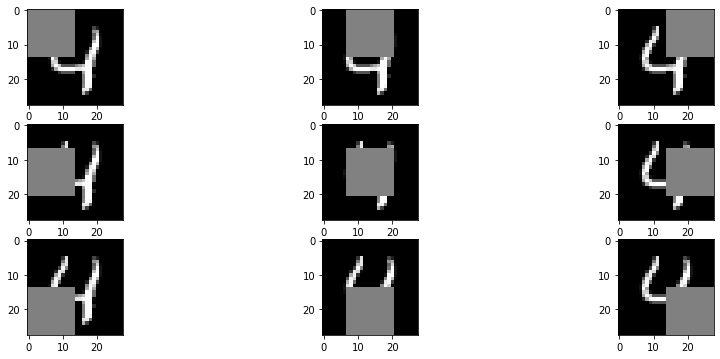

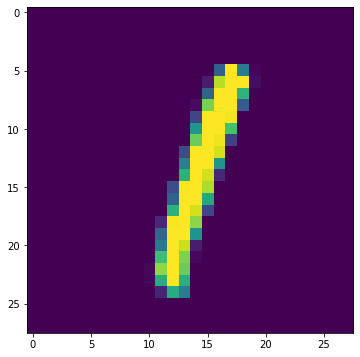

Figure:1, Actual Class:1, Probability:0.7302, Predicted:1
Figure:2, Actual Class:1, Probability:0.5362, Predicted:1
Figure:3, Actual Class:1, Probability:0.7716, Predicted:1
Figure:4, Actual Class:1, Probability:0.8439, Predicted:1
Figure:5, Actual Class:1, Probability:0.0591, Predicted:7
Figure:6, Actual Class:1, Probability:0.7174, Predicted:1
Figure:7, Actual Class:1, Probability:0.9957, Predicted:1
Figure:8, Actual Class:1, Probability:0.8741, Predicted:1
Figure:9, Actual Class:1, Probability:0.9998, Predicted:1


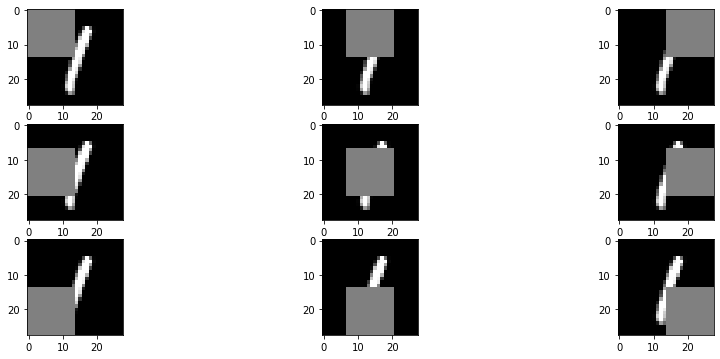

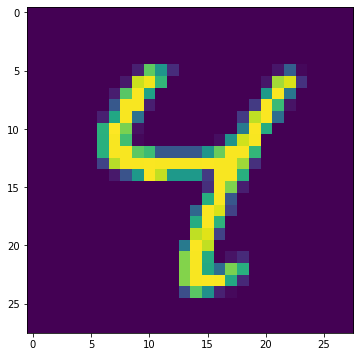

Figure:1, Actual Class:4, Probability:0.9660, Predicted:4
Figure:2, Actual Class:4, Probability:0.2716, Predicted:4
Figure:3, Actual Class:4, Probability:0.6541, Predicted:4
Figure:4, Actual Class:4, Probability:0.9942, Predicted:4
Figure:5, Actual Class:4, Probability:0.3610, Predicted:4
Figure:6, Actual Class:4, Probability:0.3638, Predicted:9
Figure:7, Actual Class:4, Probability:0.9979, Predicted:4
Figure:8, Actual Class:4, Probability:0.7967, Predicted:4
Figure:9, Actual Class:4, Probability:0.9999, Predicted:4


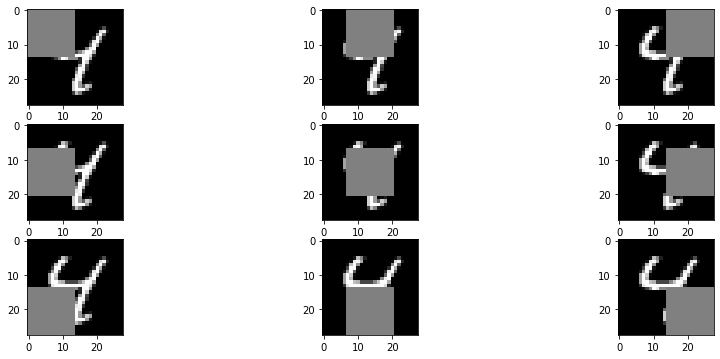

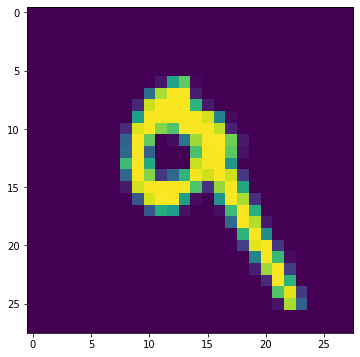

Figure:1, Actual Class:9, Probability:0.9980, Predicted:9
Figure:2, Actual Class:9, Probability:0.5890, Predicted:9
Figure:3, Actual Class:9, Probability:0.9984, Predicted:9
Figure:4, Actual Class:9, Probability:0.8048, Predicted:9
Figure:5, Actual Class:9, Probability:0.2930, Predicted:4
Figure:6, Actual Class:9, Probability:1.0000, Predicted:9
Figure:7, Actual Class:9, Probability:0.9471, Predicted:9
Figure:8, Actual Class:9, Probability:0.1985, Predicted:8
Figure:9, Actual Class:9, Probability:1.0000, Predicted:9


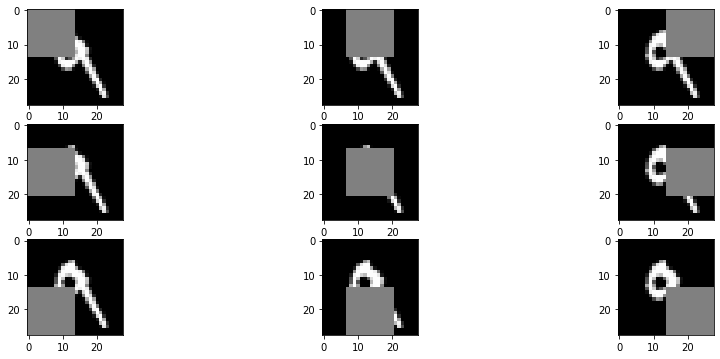

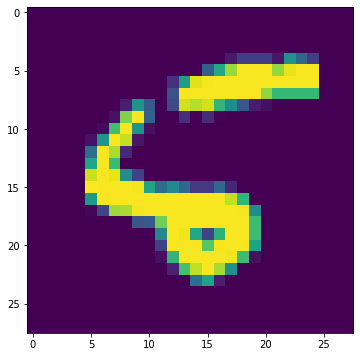

Figure:1, Actual Class:5, Probability:0.9993, Predicted:5
Figure:2, Actual Class:5, Probability:0.9071, Predicted:5
Figure:3, Actual Class:5, Probability:0.9611, Predicted:5
Figure:4, Actual Class:5, Probability:0.9998, Predicted:5
Figure:5, Actual Class:5, Probability:0.9222, Predicted:5
Figure:6, Actual Class:5, Probability:0.5127, Predicted:5
Figure:7, Actual Class:5, Probability:1.0000, Predicted:5
Figure:8, Actual Class:5, Probability:1.0000, Predicted:5
Figure:9, Actual Class:5, Probability:0.9953, Predicted:5


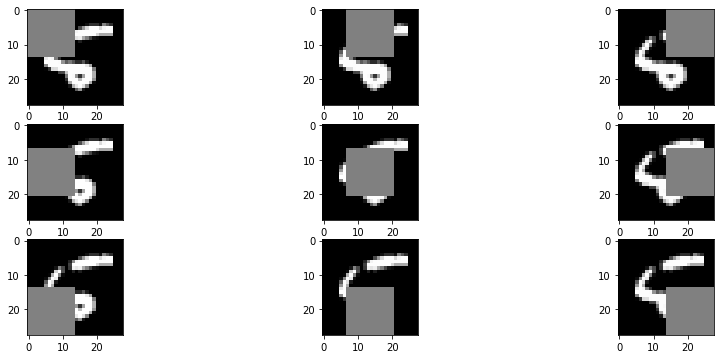

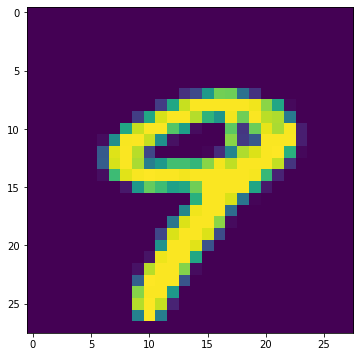

Figure:1, Actual Class:9, Probability:0.9788, Predicted:9
Figure:2, Actual Class:9, Probability:0.0240, Predicted:4
Figure:3, Actual Class:9, Probability:0.7417, Predicted:9
Figure:4, Actual Class:9, Probability:0.9677, Predicted:9
Figure:5, Actual Class:9, Probability:0.1103, Predicted:7
Figure:6, Actual Class:9, Probability:0.9968, Predicted:9
Figure:7, Actual Class:9, Probability:0.3306, Predicted:8
Figure:8, Actual Class:9, Probability:0.0827, Predicted:8
Figure:9, Actual Class:9, Probability:1.0000, Predicted:9


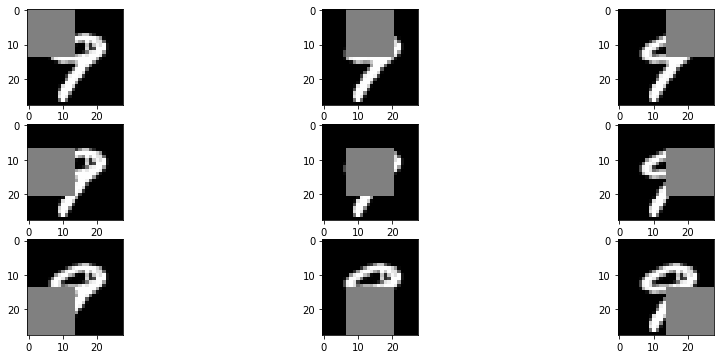

In [45]:
test_image = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)

cnt = 0
for images,labels in test_image:
  images = images.to(device)
  labels = labels.to(device)
  img = images.cpu().numpy().reshape(28,28)
  plt.figure(figsize=(15,6))
  plt.imshow(img)
  plt.show()
  col,row = 3,3
  fig =   plt.figure(figsize=(15,6))
  for i in range(1,10):
    fig.add_subplot(row,col,i)
   
    oc_image = occluded_image(img,7*int((i-1)/3),7*((i-1)%3))
    #fig = plt.figure(figsize=(15,6))
    plt.imshow(oc_image,'gray')
    image = torch.from_numpy(oc_image.reshape(1,1,28,28))
    image = image.to(device)
    preds = model(image)
    for ii in labels.cpu().numpy():
      idx = ii
    
    pred_ = preds.data.cpu().numpy()
    predicted = np.argmax(pred_)
    pred_ = np.exp(pred_)/np.sum(np.exp(pred_))
    print('Figure:{}, Actual Class:{}, Probability:{:.4f}, Predicted:{}'.format(i,idx,pred_[0,idx],predicted))
  plt.show()
  cnt += 1
  if cnt == 10:
    break




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


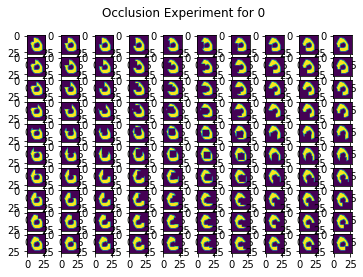

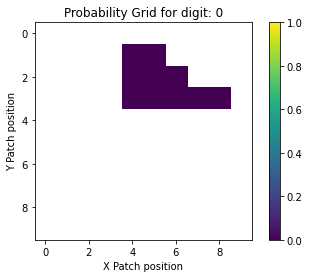

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 3. 3. 3. 0. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 7. 7. 7. 0.]
 [0. 0. 0. 2. 2. 2. 5. 7. 7. 7.]
 [0. 0. 0. 0. 0. 0. 0. 7. 7. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 6. 6. 6. 0. 0. 0. 0. 0.]
 [0. 0. 0. 6. 6. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


<Figure size 432x288 with 0 Axes>

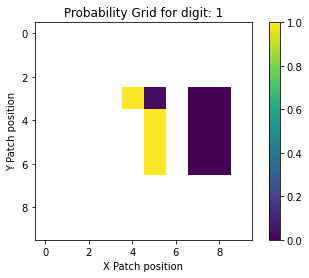

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 4. 4. 1.]
 [1. 8. 8. 1. 1. 5. 1. 3. 4. 1.]
 [1. 8. 8. 1. 1. 5. 1. 3. 4. 1.]
 [1. 8. 8. 1. 1. 5. 1. 3. 4. 1.]
 [1. 1. 8. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


<Figure size 432x288 with 0 Axes>

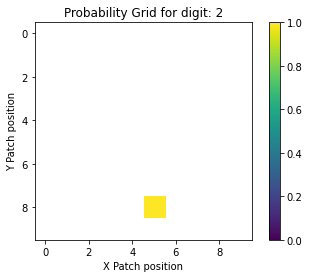

[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 7. 2. 2. 2. 7.]
 [2. 2. 2. 2. 2. 7. 7. 7. 7. 7.]
 [2. 2. 2. 2. 2. 2. 2. 2. 3. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 7. 7. 7. 7. 2.]
 [2. 2. 2. 2. 2. 7. 7. 7. 7. 2.]]


<Figure size 432x288 with 0 Axes>

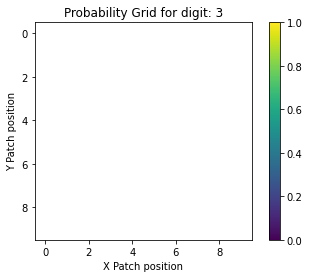

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 5. 5. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 5. 5. 5. 2. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]


<Figure size 432x288 with 0 Axes>

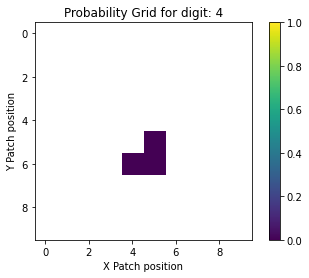

[[4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 5. 4. 4. 4. 4.]
 [4. 4. 4. 4. 5. 5. 4. 4. 4. 4.]
 [4. 4. 4. 4. 5. 5. 4. 4. 4. 4.]
 [4. 4. 4. 4. 9. 5. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]]


<Figure size 432x288 with 0 Axes>

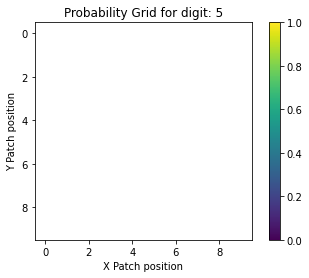

[[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]


<Figure size 432x288 with 0 Axes>

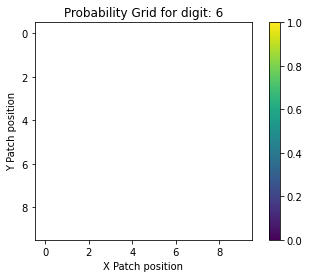

[[6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 4. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 4. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]]


<Figure size 432x288 with 0 Axes>

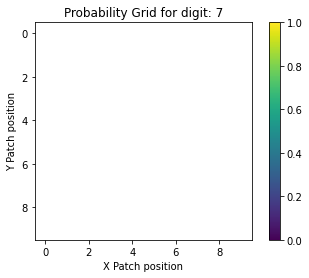

[[7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 5. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]]


<Figure size 432x288 with 0 Axes>

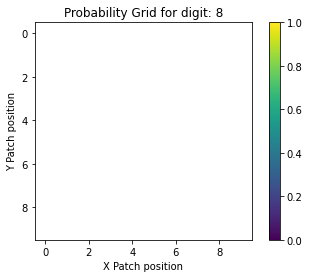

[[8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 8. 8. 3. 8. 8. 8.]
 [8. 8. 8. 8. 8. 3. 3. 8. 8. 8.]
 [8. 8. 8. 8. 8. 3. 3. 3. 8. 8.]
 [8. 8. 8. 8. 8. 8. 3. 8. 8. 8.]
 [8. 8. 8. 8. 8. 5. 8. 8. 8. 8.]
 [8. 8. 8. 8. 5. 8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]]


<Figure size 432x288 with 0 Axes>

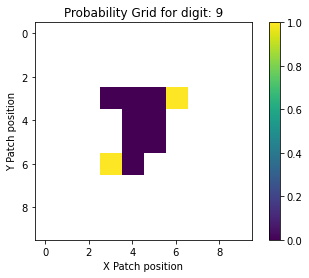

[[9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [4. 4. 9. 4. 9. 7. 9. 9. 9. 9.]
 [4. 4. 4. 4. 7. 7. 7. 9. 9. 9.]
 [9. 9. 9. 9. 7. 7. 9. 9. 9. 9.]
 [9. 9. 9. 9. 7. 7. 9. 9. 9. 9.]
 [9. 9. 4. 4. 5. 5. 9. 9. 9. 9.]
 [9. 9. 4. 4. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]]


In [46]:
number_list = [6003,416,6754,1605,5055,7965,517,5551,7070,6420] 

patch_size = int(10)
stride     = int(2)
dim        = int((28-patch_size)/stride + 1) #28 is W,H input

data_ind = number_list 

for j in range(len(data_ind)):
#for images,labels in test_image:
#   images = images.to(device)
#   labels = labels.to(device)
    ind = data_ind[j]
    i = 1 #a dummy counter
    test_image = test_loader.dataset.data[ind].clone() 
    true_label = test_loader.dataset[ind][1]
    #test_image = test_image.to(device)
    #true_label = true_label.to(device)
    #test_image = test_image.cpu().numpy().reshape(28,28)


    probability_matrix = np.zeros((dim,dim), dtype = np.float) 
    predicted_class    = np.zeros(probability_matrix.shape) 

    for y in range(0,(28-patch_size)+1,stride):
        for x in range(0,(28-patch_size)+1,stride): 
            occl_image = test_image.clone() 
            occl_image[x:x+patch_size,y:y+patch_size] = 0 

            with torch.no_grad():

                    
                    #if(device == torch.device("cuda")): 
                    occl_image = occl_image.reshape(1,1,28,28).cuda().float() 

                    #else:
                    #occl_image = occl_image.reshape(1,1,28,28).float()
                    
                    #print(test_image)

                    #occl_image = torch.from_numpy(occl_image.reshape(1,1,28,28))
                    #occl_image = occl_image.to(device)

                    pred = model.forward(occl_image).detach().cpu().numpy() 
                    #pred  = model(occl_image)
                    pred_class = np.argmax(pred) #predicted class
                    #pred = np.exp(pred)/np.sum(np.exp(pred))

                    
                    pred = np.exp(pred) #now in the form of probabilities

                    probability_matrix[int(y/stride),int(x/stride)] = pred[:,j] 
                    predicted_class[int(y/stride),int(x/stride)]    = pred_class
                    if(ind == data_ind[0]): 
                        plt.subplot(dim,dim,i)
                        i += 1
                        plt.imshow(occl_image.cpu().numpy().reshape(28,28)) 

    plt.suptitle("Occlusion Experiment for 0")
    plt.tight_layout()
    plt.show()


    #Plot of the probability matrix       
    plt.imshow(probability_matrix, interpolation='nearest', cmap=plt.cm.viridis)
    plt.colorbar()
    plt.clim(0,1)
    plt.title('Probability Grid for digit: '+str(j))
    plt.ylabel('Y Patch position')
    plt.xlabel('X Patch position')
    plt.show()

    #Plot of the Predicted Class
    print(predicted_class)
    #print(probability_matrix)
                                

# 3. Adversarial Examples

### <font color='red'> 3.1 Non Targeted Attack</font >

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


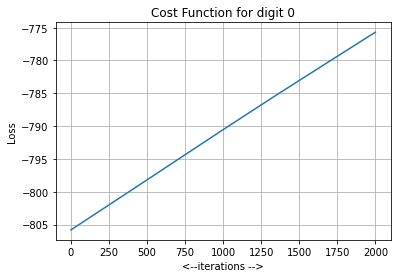

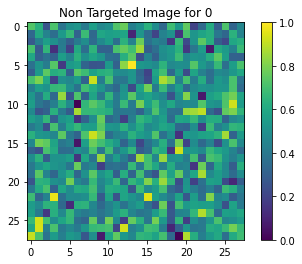

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


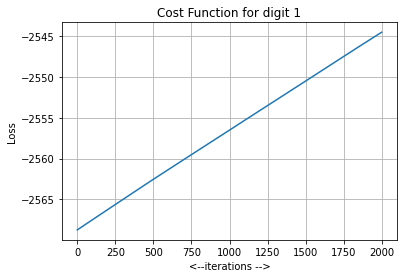

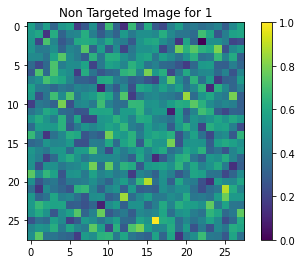

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


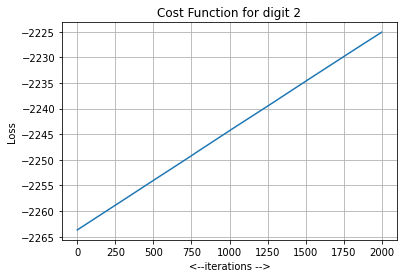

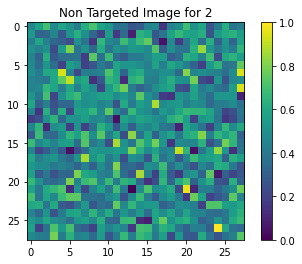

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


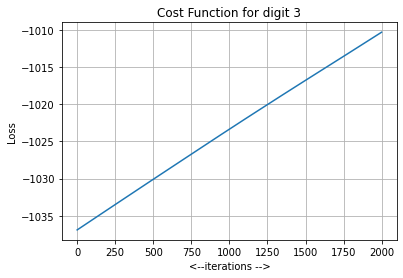

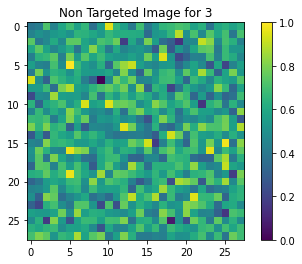

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


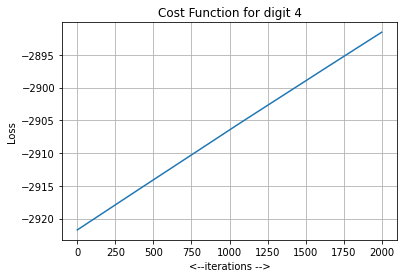

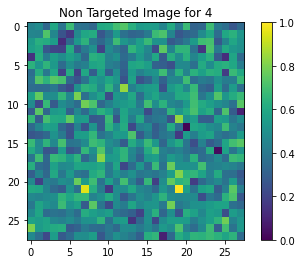

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


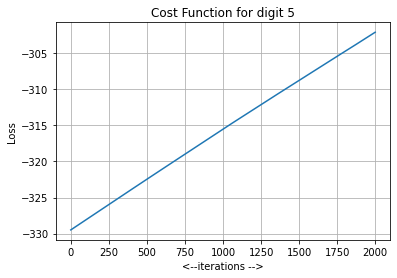

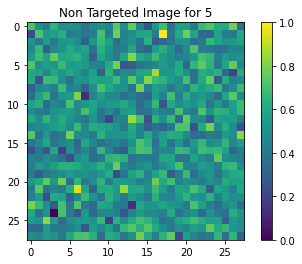

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


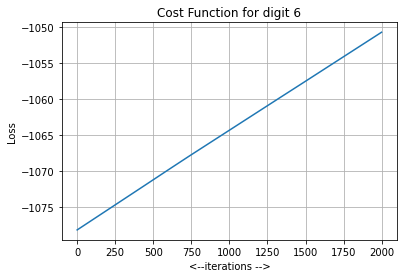

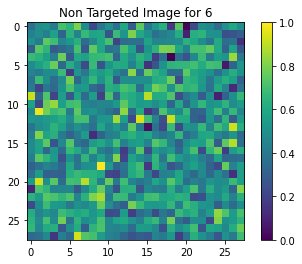

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


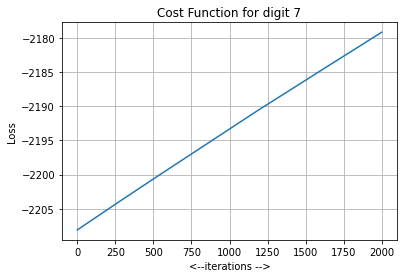

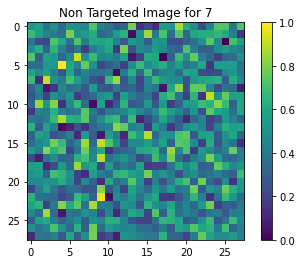

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


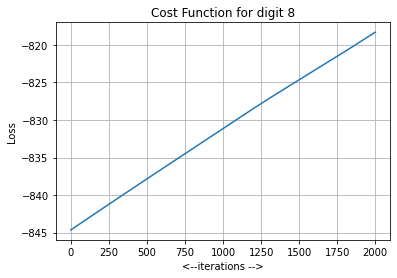

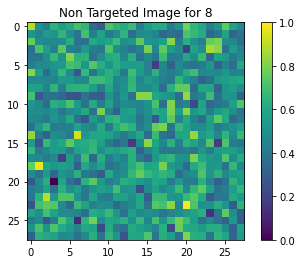

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


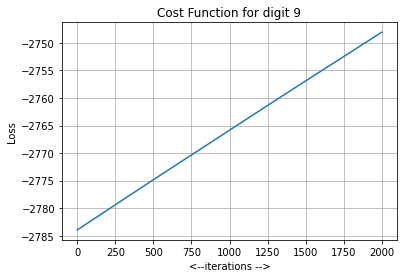

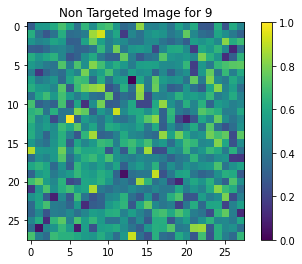

In [47]:
 #keeps changing the noise till it resembles some class
for j in range(10): # j takes the values from 0 to 9

    target_class = j 
    noise        = np.random.normal(loc = 128, scale = 8, size = (28,28)).reshape(1,1,28,28) 
    noise        = torch.from_numpy(noise)

    noise_tensor = torch.tensor(noise.type(torch.FloatTensor), requires_grad=True)
    logit_cost = [] 
    optim=torch.optim.Adam([noise_tensor], lr=0.0001)

    for i in range(2000):
        optim.zero_grad()
        #forward pass
        output = model.layer1.forward(noise_tensor.cuda())
        output = model.layer2.forward(output)
        output = flatten(output,1)
        output = model.fc_layer1.forward(output)
        logit  = model.fc_layer2.forward(output)
        loss   = -logit[:,target_class] 

        logit_cost.append(logit[:,target_class].cpu().detach().numpy())

        loss.backward(retain_graph = True)

        optim.step()
    plt.plot(np.asfarray(logit_cost))
    plt.title('Cost Function for digit '+str(target_class))
    plt.xlabel('<--iterations -->')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

    #normalization
    NT_plot = noise_tensor.cpu().reshape(28,28).detach().numpy()
    NT_plot = NT_plot - np.min(NT_plot)
    NT_plot = NT_plot/np.max(NT_plot)

    plt.imshow(NT_plot,cmap = plt.cm.viridis)
    plt.colorbar()
    plt.title("Non Targeted Image for "+str(target_class))
    plt.show()

### <font color ='red'>3.2 Adding noise

Enter the digit you'd want the generated image to look like5
What digit would you want this image to be recognized as?7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp


Predicted Class:  5
Confidence in prediction: [0.]
Enter the digit you'd want to add the noise matrix to8
Predicted Class:  8
Confidence in prediction: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in exp


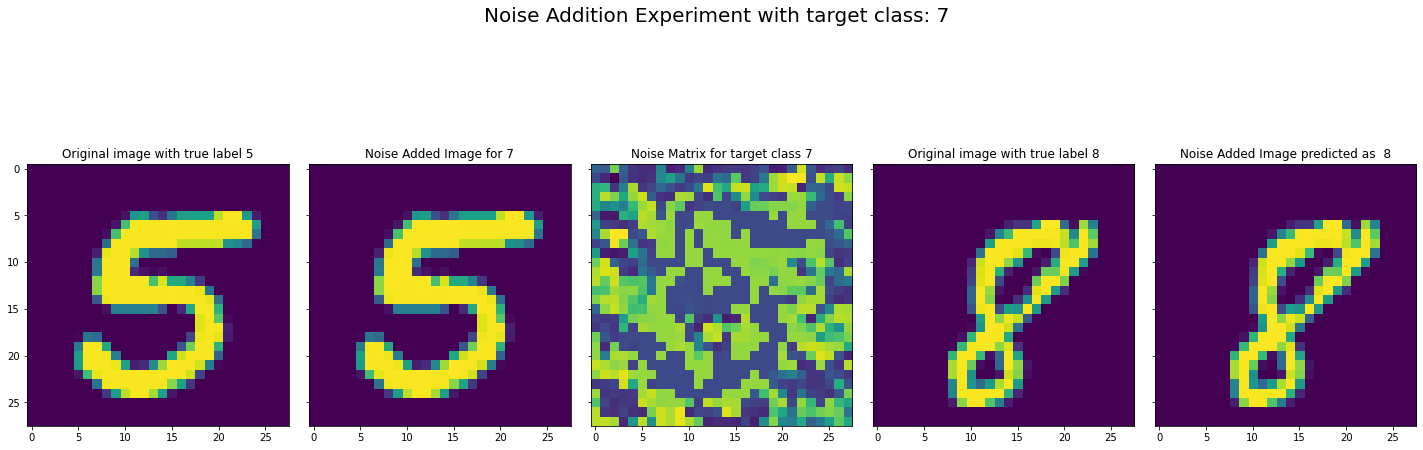

In [83]:

#we can let the user choose the set of original image and target classes

orig_class = int(input("Enter the digit you'd want the generated image to look like"))
target_class = int(input("What digit would you want this image to be recognized as?"))

orig_image = test_loader.dataset.data[number_list[orig_class]].clone() 

if(device == torch.device("cuda")): 
    orig_image = orig_image.reshape(1,1,28,28).cuda().float()

else:
    orig_image = orig_image.reshape(1,1,28,28).float()

fig,axs = plt.subplots(1,5,figsize = (20,20))

#plotting the original image
axs[0].imshow(orig_image.detach().cpu().numpy().reshape(28,28)) 
axs[0].set_title("Original image with true label "+str(orig_class))

#initializing noise matrix
noise = np.zeros((1,1,28,28),dtype = np.float)
noise = torch.from_numpy(noise)
noise_tensor = torch.tensor(noise.type(torch.FloatTensor), requires_grad=True)

optim=torch.optim.Adam([noise_tensor], lr=0.0001)
for i in range(1000):
    X = orig_image + noise_tensor
    optim.zero_grad()
    
    output = model.layer1.forward(X.cuda())
    output = model.layer2.forward(output)
    output = flatten(output,1)
    output = model.fc_layer1.forward(output)
    logit  = model.fc_layer2.forward(output)

    n_logit_cost = -logit[:,target_class] 
    n_logit_cost.backward(retain_graph = True)
    optim.step() 

X = orig_image + noise_tensor
pred = model.forward(X.cuda()).detach().cpu().numpy() 
pred_class = np.argmax(pred) 
print('Predicted Class: ',pred_class)

confidence = np.exp(pred)[:,target_class] 
print('Confidence in prediction:', confidence)

#plot for the noise added image
NT_plot = X.cpu().reshape(28,28).detach().numpy()
NT_plot = NT_plot - np.min(NT_plot)
NT_plot = NT_plot/np.max(NT_plot)

axs[1].imshow(NT_plot)
axs[1].set_title("Noise Added Image for "+str(target_class))

#plot for noise
NT_plot = noise_tensor.cpu().reshape(28,28).detach().numpy()
NT_plot = NT_plot - np.min(NT_plot)
NT_plot = NT_plot/np.max(NT_plot)
axs[2].imshow(NT_plot,vmin = 0,vmax = 1)
axs[2].set_title("Noise Matrix for target class "+str(target_class))

new_orig_class = int(input("Enter the digit you'd want to add the noise matrix to")) 

new_orig_image = test_loader.dataset.data[number_list[new_orig_class]].clone() 

if(device == torch.device("cuda")): #if we're working on a GPU
    new_orig_image = new_orig_image.reshape(1,1,28,28).cuda().float() #reshaping the image into 28x28 pixels

else:
    new_orig_image = new_orig_image.reshape(1,1,28,28).float()

X = new_orig_image + noise_tensor

pred = model.forward(X.cuda()).detach().cpu().numpy() #as it is a single image we directly run the forward pass
pred_class = np.argmax(pred) #predicted class
print('Predicted Class: ',pred_class)

#pred is in the form of log_softmax and therefore, we take an exponent to convert them to probability
confidence = np.exp(pred)[:,target_class] #now in the form of probabilities

print('Confidence in prediction:', confidence)

#normalization
#plot for the noise added image
NT_plot = X.cpu().reshape(28,28).detach().numpy()
NT_plot = NT_plot - np.min(NT_plot)
NT_plot = NT_plot/np.max(NT_plot)
axs[4].imshow(NT_plot)
axs[4].set_title("Noise Added Image predicted as  "+str(pred_class))

#plot for new image
axs[3].imshow(new_orig_image.detach().cpu().numpy().reshape(28,28)) #our original image
axs[3].set_title("Original image with true label "+str(new_orig_class))

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle("Noise Addition Experiment with target class: "+str(target_class),x = 0.5,y=0.7,fontsize = 20)
fig.tight_layout()
fig.show()                                                    

# References 

https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-4-image-classification-with-cnn

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html